<a href="https://colab.research.google.com/github/moarshy/PyTorch-Projects/blob/main/ImageClassification_PyTorch_Torchvision_ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


*   In this notebook, we will build a classifier to classify three classes - cat, dog or panda
*   The datasets can be found here https://www.kaggle.com/ashishsaxena2209/animal-image-datasetdog-cat-and-panda
*   We will use PyTorch and Torchvision models ResNet18 
*   We will also try transfer learning and then train from scratch


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#importing the necessary libraries
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image

import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.models import resnet18

from torchsummary import summary

In [3]:
#Building the dataset and dataloader

In [4]:
base_path = Path('/content/drive/My Drive/Colab Notebooks/Dive into DL - Elvis Saravia/Animal Images/animals')
cats_path, dogs_path, pandas_path,(*_) = [f for f in base_path.iterdir()]

In [5]:
dataset = []
for i, c in enumerate([cats_path, dogs_path, pandas_path]):
  for f in c.iterdir():
    dataset.append((f, i))

In [6]:
dataset = np.array(dataset)
np.random.shuffle(dataset)

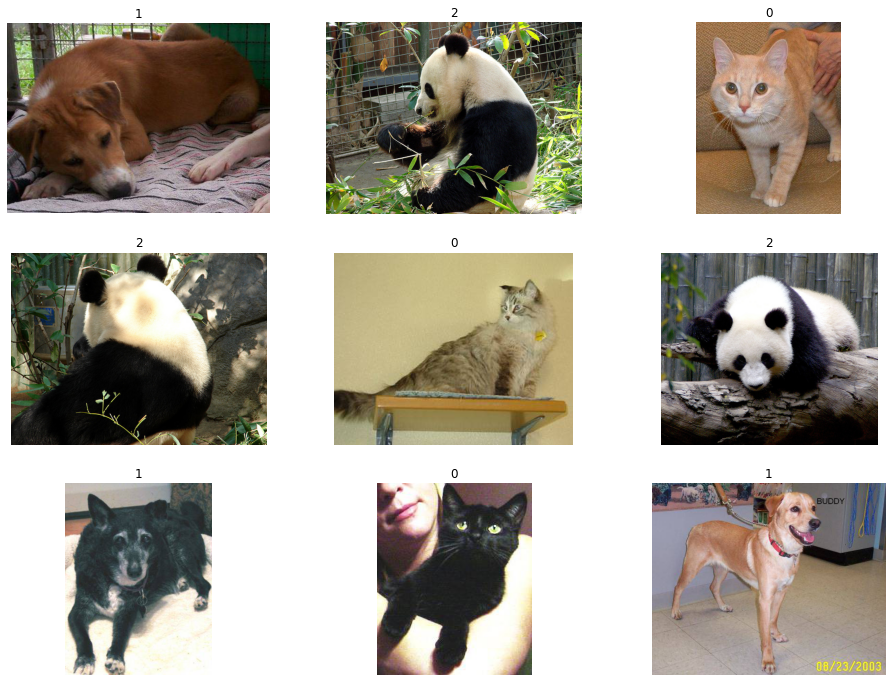

In [7]:
plt.figure(figsize=(16,12))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(Image.open(dataset[i][0]))
  plt.axis('off')
  plt.title(dataset[i][1])  

In [8]:
class ClassificationDataset:

  def __init__(self, path_target, transforms, resize=(250, 250)):
      # resize = (height, width)
        self.path_target = path_target
        self.transforms = transforms
        self.resize = resize

  def __len__(self):
    return len(self.path_target)

  def __getitem__(self, item):
    image = Image.open(self.path_target[item][0]).convert("RGB")
    targets = self.path_target[item][1]

    if self.resize is not None:
      image = image.resize(self.resize)

    image = np.transpose(image, (2, 0, 1))

    self.transforms(image)
    #image = image/255.

    return {
    "images": torch.tensor(image, dtype=torch.float),
    "targets": torch.tensor(targets, dtype=torch.long),
    }

In [9]:
#since the pretraining was done with ImageNet, we will normalise our dataset using the statistics form ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
tf_train = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((234, 234)),
                    transforms.RandomCrop((224,224)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    normalize
                    ])

tf_test = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    normalize
                    ])

In [10]:
split = int(len(dataset)*0.8)
train_ds = dataset[:split]
test_ds = dataset[split:]

In [11]:
train_ds = ClassificationDataset(train_ds, tf_train)
test_ds = ClassificationDataset(test_ds, tf_test)

In [12]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)

# Build Model and define the training function

In [16]:
class ResNet18(nn.Module):
  def __init__(self, classes, pretrain=True):
    super(ResNet18, self).__init__()
    self.res18 = resnet18(pretrained=pretrain)
    self.res18.fc = nn.Linear(self.res18.fc.in_features, 100)

    self.head = nn.Sequential(nn.BatchNorm1d(100), nn.ReLU(), nn.Linear(100, classes))
    self.model = nn.Sequential(self.res18, self.head)

    if not pretrain:
      self.initialize_weights()

  def forward(self, x):
    x = self.model(x)
    return x

  def initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight)
            
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
    
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)


In [22]:
#defining our training and evaluation dunction
def training(epochs, model, train_dl, test_dl, loss, opt, cyclical_lr):
  
  #history will hold our training & evaluation metrics
  history = []
  for epoch in range(epochs):
    train_loss = 0
    model.train()
    loop = tqdm(enumerate(train_dl), leave=False, total=len(train_dl))
    for i, data in loop:
      img = data['images'].to(device)
      label = data['targets']
      label = torch.tensor(label, dtype=torch.long).to(device)

      output = model(img)
      
      running_train_loss = loss(output, label)
      train_loss += running_train_loss.item()

      opt.zero_grad()
      running_train_loss.backward()
      opt.step()
      cyclical_lr.step()

      loop.set_description(f'Epoch {epoch}/{epochs}')
      loop.set_postfix(loss=running_train_loss.item())

    train_loss /= len(train_dl)
    
    model.eval()
    with torch.no_grad(): 
      valid_loss = 0
      total = 0
      correct= 0
      for data in test_dl:
        img = data['images'].to(device)
        label = data['targets']
        label = torch.tensor(label, dtype=torch.long).to(device)

        output = model(img)
        
        running_valid_loss = loss(output, label)
        valid_loss += running_valid_loss.item()
        
        output = torch.log_softmax(output,dim=1)
        _, pred = torch.max(output, 1)

        correct += (pred == label).sum().item()
        total += len(label)

      valid_loss /= len(test_dl)
      acc = (correct/total) * 100
    print(f'Epoch: {epoch}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, Accuracy: {acc:.2f}')
    history.append((epoch, train_loss, valid_loss, acc))

  return history

# Train with transfer learning

In [23]:
model = ResNet18(3, pretrain=True)

In [24]:
#set all resnet layers except the last two nn.Linear to not train
for param in model.res18.parameters():
  param.requires_grad = False

In [25]:
#defining the hyperparameters
epochs = 15
lr = 1e-4

#setting the device and moving the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

#defining our loss
loss = nn.CrossEntropyLoss()

In [26]:
#Training the torchvision pretrained ResNet18
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
cyclical_lr = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=lr, max_lr=lr*100,cycle_momentum=False)
history = training(epochs, model, train_dl, test_dl, loss, opt, cyclical_lr)
pd.DataFrame(history, columns=['Epochs', 'Training Loss', 'Valid Loss', 'Accuracy']).to_excel(base_path/'hist_r18.xlsx')

  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

Epoch: 0, Train Loss: 1.0028577462832133, Valid Loss: 0.8444073764901412, Accuracy: 73.33


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.7050861529509227, Valid Loss: 0.5271575827347604, Accuracy: 90.00


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.44281394441922506, Valid Loss: 0.3388321572228482, Accuracy: 92.17


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.29455575068791706, Valid Loss: 0.24497074516196, Accuracy: 93.50


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.23826957255601883, Valid Loss: 0.1977164063014482, Accuracy: 93.67


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.18132728909452756, Valid Loss: 0.17263313539718328, Accuracy: 94.50


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.15790261462330818, Valid Loss: 0.14929004797810003, Accuracy: 95.17


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 0.14749773919582368, Valid Loss: 0.14413340036806307, Accuracy: 94.67


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.13879823898275692, Valid Loss: 0.1356454538671594, Accuracy: 95.33


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.13080738566815853, Valid Loss: 0.13541349121614507, Accuracy: 95.17


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 0.11838708688815434, Valid Loss: 0.1265615022888309, Accuracy: 95.33


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 11, Train Loss: 0.12457447335124015, Valid Loss: 0.12008667482357276, Accuracy: 96.17


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 12, Train Loss: 0.11329067718237638, Valid Loss: 0.11489703878760338, Accuracy: 95.67


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 13, Train Loss: 0.12221135479708513, Valid Loss: 0.11825413100029293, Accuracy: 95.50


Epoch: 14, Train Loss: 0.12465975414961576, Valid Loss: 0.11406621866320309, Accuracy: 96.00


# Traing from scratch

In [29]:
model_s = ResNet18(3, pretrain=False)
model_s.to(device)

ResNet18(
  (res18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [30]:
#Training the torchvision without pretriaining
opt = torch.optim.Adam(model_s.parameters(), lr=lr, weight_decay=1e-5)
cyclical_lr = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=lr, max_lr=lr*100,cycle_momentum=False)
history = training(epochs, model_s, train_dl, test_dl, loss, opt, cyclical_lr)
pd.DataFrame(history, columns=['Epochs', 'Training Loss', 'Valid Loss', 'Accuracy']).to_excel(base_path/'hist_r18_s.xlsx')


  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]

Epoch 0/15: 100%|██████████| 75/75 [00:36<00:00,  2.09it/s, loss=0.874]
                                                                       /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.8211438234647115, Valid Loss: 1.2580492088669224, Accuracy: 60.67



Epoch 1/15: 100%|██████████| 75/75 [00:35<00:00,  2.11it/s, loss=0.73]
                                                                      
  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.6873831915855407, Valid Loss: 0.7766414065110055, Accuracy: 63.83



Epoch 2/15: 100%|██████████| 75/75 [00:35<00:00,  2.11it/s, loss=0.503]
                                                                       
  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.6527355078856151, Valid Loss: 1.8870019849977995, Accuracy: 44.17



Epoch 3/15: 100%|██████████| 75/75 [00:35<00:00,  2.08it/s, loss=0.839]
                                                                       
  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.6321722463766734, Valid Loss: 0.6991474346110695, Accuracy: 66.33



Epoch 4/15: 100%|██████████| 75/75 [00:35<00:00,  2.11it/s, loss=0.645]
                                                                       
  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.6018509904543559, Valid Loss: 0.7081512934283206, Accuracy: 62.50



Epoch 5/15: 100%|██████████| 75/75 [00:35<00:00,  2.15it/s, loss=0.604]
                                                                       
  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.584769922097524, Valid Loss: 1.3929223669202704, Accuracy: 58.00



Epoch 6/15: 100%|██████████| 75/75 [00:35<00:00,  2.12it/s, loss=0.529]
                                                                       
  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.5708941419919332, Valid Loss: 0.8493639387582478, Accuracy: 63.33



Epoch 7/15: 100%|██████████| 75/75 [00:35<00:00,  2.10it/s, loss=0.561]
                                                                       
  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 0.5544222621122996, Valid Loss: 1.4259371412427801, Accuracy: 50.17



Epoch 8/15: 100%|██████████| 75/75 [00:35<00:00,  2.07it/s, loss=0.377]
                                                                       
  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.5286127281188965, Valid Loss: 1.0783417883672213, Accuracy: 61.17



Epoch 9/15: 100%|██████████| 75/75 [00:35<00:00,  2.15it/s, loss=0.539]
                                                                       
  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.5273232686519623, Valid Loss: 0.6722621604015953, Accuracy: 67.50



Epoch 10/15: 100%|██████████| 75/75 [00:35<00:00,  2.16it/s, loss=0.433]
                                                                        
  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 0.5110647928714752, Valid Loss: 0.8755651147742021, Accuracy: 58.83



Epoch 11/15: 100%|██████████| 75/75 [00:35<00:00,  2.10it/s, loss=0.527]
                                                                        
  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 11, Train Loss: 0.47590813517570496, Valid Loss: 1.4110802663000006, Accuracy: 45.00



Epoch 12/15: 100%|██████████| 75/75 [00:35<00:00,  2.17it/s, loss=0.677]
                                                                        
  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 12, Train Loss: 0.4674400754769643, Valid Loss: 3.4330626537925317, Accuracy: 49.67



Epoch 13/15: 100%|██████████| 75/75 [00:35<00:00,  2.14it/s, loss=0.545]
                                                                        
  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 13, Train Loss: 0.4495229117075602, Valid Loss: 0.9210192467037001, Accuracy: 58.50



Epoch 14/15: 100%|██████████| 75/75 [00:35<00:00,  2.14it/s, loss=0.846]
                                                                        

Epoch: 14, Train Loss: 0.4400958341360092, Valid Loss: 0.868487907083411, Accuracy: 65.17
